<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP_V07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Disciplina Machine Learning & Analytics - Modelo Deep Learning - MVP Letra b.

**b.** Modelo baseado em Deep Learning para resolver problema de Classificação de Texto e Análise de Sentimento em Processamento de Linguagem Natural (PLN).</br>
**DataSet:** Amazon Cell Phones Reviews https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews. É uma base de avaliação de celulares, foi escolhida por questão didática para ilustrar um problema de classificação de texto e análise de sentimento. O dataset possui um conjunto de informações sobre as avaliações, como por exemplo: nome do avaliador, data, utilidade, body e rating. Para o escopo desse trabalho selecionamos 2 atributos do dataset: body e rating, sendo o body a avaliação do celular e o rating uma nota atribuída pelo avaliador que pode variar de 1 até 5, sendo 1 muito ruim e 5 excelente.</br>
**Qual é a descrição do problema?** É um problema de classificação de texto e análise de sentimento. Dado o texto de uma avaliação de celular precisamos determinar se a avaliação é positiva ou negativa.</br>
**Você tem premissas ou hipóteses sobre o problema? Quais?** Foi observado por amostragem que avaliações 1 e 2 são mais negativas enquanto 4 e 5 mais positivas. Vamos realizar a classificação com 5 classes para avaliação dos resultados, entretanto acredito que transformar o problema em uma classificação binária, para definir se a avaliação é positiva ou negativa deve apresentar uma melhor performance. </br>

In [124]:
!pip install tensorflow-text

In [125]:
import numpy as np
import pandas as pd
import pickle
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text
import warnings
warnings.filterwarnings("ignore")

In [126]:
CARGA_PESOS_MODELO_BIN = False
CARGA_PESOS_MODELO_MLT = False
PATH_PESOS_COLAB_FILE_BIN = '/content/bert_mvp/pesos_modelo_bin.h5'
PATH_PESOS_COLAB_FILE_MLT = '/content/bert_mvp/pesos_modelo_mlt.h5'
PATH_PESOS_COLAB_FOLDER = '/content/bert_mvp/'

In [127]:
if os.path.exists(PATH_PESOS_COLAB_FOLDER):
  shutil.rmtree(PATH_PESOS_COLAB_FOLDER)

os.makedirs(PATH_PESOS_COLAB_FOLDER, exist_ok=True) # cria a pasta de destino se necessário

# Importando DataSet Amazon Cell Phones Reviews.
Vamos trabalhar com 2 instâncias do dataset, a primeira para classificação multiclasse (df_mult) e o segundo para classificação binária. O objetivo é comparar a performance das 2 abordagens.

In [128]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/20191226-reviews.csv"

# Lê o arquivo
df_mult = pd.read_csv(url, delimiter=',', encoding='latin-1')
df_bin = pd.read_csv(url, delimiter=',', encoding='latin-1')

df_bin.head(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


# Preparação e pre-processamento dos Dados
Realizamos algumas operações para simplificação dos dados e adequação antes de submeter para  pre-processamento e treinamento.
*   Vamos trabalhar com um subconjunto de 10.000 registros
*   Para o dataset utilizado na classificação binária vamos adaptar a coluna "rating" da seguinte forma: os valores 1 e 2 vão ser transformados em "0", os valores 4 e 5 serão convertidos em "1" e o valor 3 "None".
*   Remover as linhas que contêm valores ausentes (NaN)
*   Redefinir os índices do DataFrame após a remoção das linhas com valores ausentes.
*   Remove caracteres especiais não reconhecidos, usando encode e decode entre os padrões ASCII e UTF-8
*   Seleciona somente as colunas "Body" e "Rating" que vão ser parte do escopo do trabalho.

In [129]:
df_mult = df_mult.head(10000)
df_bin = df_bin.head(10000)

In [130]:
mapping={1:0,2:0,3:None,4:1,5:1}
df_bin.rating=df_bin.rating.map(mapping)
df_bin=df_bin.dropna(subset='rating')

In [131]:
df_mult = df_mult.dropna()
df_mult = df_mult.reset_index(drop=True)

df_bin = df_bin.dropna()
df_bin = df_bin.reset_index(drop=True)

In [132]:
#import re
#df_bin["rating"] = df_bin["rating"].astype(int)
#df_mult["rating"] = df_mult["rating"].astype(int)

In [133]:
rat_bin=df_bin.rating.value_counts()
rat_mult=df_mult.rating.value_counts()

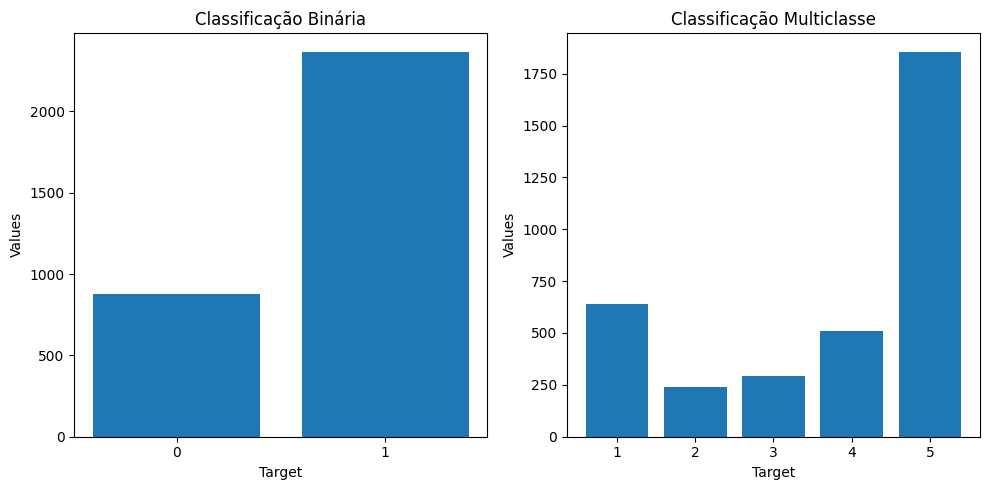

In [134]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_bin.index, rat_bin.values)
axes[0].set_xticks(rat_bin.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Classificação Binária')

# Plotagem do segundo gráfico
axes[1].bar(rat_mult.index, rat_mult.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Classificação Multiclasse')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [135]:
df_bin.loc[:, "body"] = df_bin["body"].str.encode("ascii", "ignore").str.decode("utf-8")
df_bin.loc[:, "body"] = df_mult["body"].str.encode("ascii", "ignore").str.decode("utf-8")

In [136]:
df_bin = df_bin[["body", "rating"]]
df_mult = df_mult[["body", "rating"]]
df_mult.loc[:, "rating"] = df_mult["rating"].astype(float)

In [137]:
df_mult.head(10)

,body,rating
0,I had the Samsung A600 for awhile which is abs...,3.0
1,Due to a software issue between Nokia and Spri...,1.0
2,"This is a great, reliable phone. I also purcha...",5.0
3,"I love the phone and all, because I really did...",3.0
4,The phone has been great for every purpose it ...,4.0
5,Cool. Cheap. Color: 3 words that describe the ...,5.0
6,"The 3599i is overall a nice phone, except that...",4.0
7,"I've never owned a Nokia phone before, so this...",5.0
8,ok well im in school and i need the text messa...,3.0
9,I've had this phone for over a year and I real...,4.0


# Separação em base de treino e teste

In [138]:
X_train, X_test, y_train, y_test = train_test_split(df_bin.body,df_bin.rating,test_size=0.2)
R_train, R_test, t_train, t_test = train_test_split(df_mult.body,df_mult.rating,test_size=0.2)

# Carrega o BERT preprocessor e encoder
O modelo BERT (Bidirectional Encoder Representations from Transformers) é um modelo de linguagem pré-treinado desenvolvido pelo Google que possui uma arquitetura baseada em transformers. No escopo desse trabalho o BERT foi utilizado para classificação de texto.

In [139]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [140]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']
get_sentense_embeding([
    df_bin.body[5],df_bin.body[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.66974694, -0.55856156, -0.9775242 , ..., -0.939019  ,
        -0.6770846 ,  0.6674904 ],
       [-0.78146726, -0.6098954 , -0.9507825 , ..., -0.92656064,
        -0.7495821 ,  0.5948985 ]], dtype=float32)>

In [141]:
#1 neuronio de saída com ativação sigmoid
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
model_bin=tf.keras.Model(inputs=[text_input],outputs=[l])


#Alterado para considerar as 5 classses e ativação softmax
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model_mult=tf.keras.Model(inputs=[text_input],outputs=[l])

In [142]:
model_bin.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_8 (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [143]:
METRICS_BIN=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_MULT=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_mult.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS_MULT)
model_bin.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS_BIN)

In [144]:
if CARGA_PESOS_MODELO_BIN:
  model_bin.load_weights(PATH_PESOS_COLAB_FILE_BIN) #Carrega os pesos do modelo
  history = keras.callbacks.History()
  path = PATH_PESOS_COLAB_FOLDER + 'history_bin.pkl'
  with open(path, 'rb') as f:
    history.history = pickle.load(f)
else:
  history = model_bin.fit(X_train,y_train,epochs=10)
  model_bin.save_weights(PATH_PESOS_COLAB_FILE_BIN) #Salva os pesos do modelo
  # Salvar o histórico de treinamento
  path = PATH_PESOS_COLAB_FOLDER + 'history_bin.pkl'
  with open(path, 'wb') as f:
      pickle.dump(history.history, f)

Epoch 1/10
82/82 [==============================] - 37s 318ms/step - loss: 0.6210 - accuracy: 0.7044 - precision: 0.7231 - recall: 0.9590
Epoch 2/10
82/82 [==============================] - 27s 325ms/step - loss: 0.6085 - accuracy: 0.7222 - precision: 0.7237 - recall: 0.9968
Epoch 3/10
82/82 [==============================] - 26s 322ms/step - loss: 0.6005 - accuracy: 0.7195 - precision: 0.7233 - recall: 0.9920
Epoch 4/10
82/82 [==============================] - 26s 317ms/step - loss: 0.5960 - accuracy: 0.7233 - precision: 0.7251 - recall: 0.9952
Epoch 5/10
82/82 [==============================] - 26s 319ms/step - loss: 0.6024 - accuracy: 0.7222 - precision: 0.7241 - recall: 0.9957
Epoch 6/10
82/82 [==============================] - 26s 322ms/step - loss: 0.6097 - accuracy: 0.7175 - precision: 0.7233 - recall: 0.9878
Epoch 7/10
82/82 [==============================] - 26s 320ms/step - loss: 0.6040 - accuracy: 0.7229 - precision: 0.7246 - recall: 0.9957
Epoch 8/10
82/82 [================

In [ ]:
if CARGA_PESOS_MODELO_MLT:
  model_bin.load_weights(PATH_PESOS_COLAB_FILE_MLT) #Carrega os pesos do modelo
  history_mult = keras.callbacks.History()
  path = PATH_PESOS_COLAB_FOLDER + 'history_mlt.pkl'
  with open(path, 'rb') as f:
    history_mult.history = pickle.load(f)
else:
  #Converta os rótulos de classe em codificação one-hot
  t_train_adjusted = t_train - 1
  t_train_one_hot = tf.keras.utils.to_categorical(t_train_adjusted, num_classes=5)
  #print(t_train_one_hot)
  history_mult = model_mult.fit(R_train,t_train_one_hot,epochs=10)
  model_mult.save_weights(PATH_PESOS_COLAB_FILE_MLT) #Salva os pesos do modelo
  # Salvar o histórico de treinamento
  path = PATH_PESOS_COLAB_FOLDER + 'history_mlt.pkl'
  with open(path, 'wb') as f:
      pickle.dump(history_mult.history, f)

Epoch 1/10
89/89 [==============================] - 31s 321ms/step - loss: 1.3925 - accuracy: 0.5014 - precision: 0.5562 - recall: 0.3218
Epoch 2/10
89/89 [==============================] - 29s 324ms/step - loss: 1.2865 - accuracy: 0.5265 - precision: 0.6108 - recall: 0.3479
Epoch 3/10
89/89 [==============================] - 29s 325ms/step - loss: 1.2569 - accuracy: 0.5470 - precision: 0.6623 - recall: 0.3731
Epoch 4/10
89/89 [==============================] - 29s 321ms/step - loss: 1.2122 - accuracy: 0.5605 - precision: 0.6792 - recall: 0.3907
Epoch 5/10
28/89 [========>.....................] - ETA: 19s - loss: 1.1669 - accuracy: 0.5826 - precision: 0.6846 - recall: 0.4263

In [ ]:
#Converta os rótulos de classe em codificação one-hot
#t_train_adjusted = t_train - 1
#t_train_one_hot = tf.keras.utils.to_categorical(t_train_adjusted, num_classes=5)
#print(t_train_one_hot)
#history_mult = model_mult.fit(R_train,t_train_one_hot,epochs=2)

In [ ]:
type(history)

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Obtendo os scores de treinamento do histórico
train_scores_mult = history_mult.history['accuracy']
train_scores = history.history['accuracy']

# Plotando a curva de aprendizado
axes[0].plot(range(1, 11), train_scores, label='Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Aprendizado Binário')
axes[0].legend()


# Plotando a curva de aprendizado
axes[1].plot(range(1, 11), train_scores_mult, label='Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia')
axes[1].set_title('Curva de Aprendizado 5 Classes')
axes[1].legend()

plt.show()


In [ ]:
model_bin.evaluate(X_test,y_test)

In [ ]:
#Converta os rótulos de classe em codificação one-hot
t_test_adjusted = t_test - 1
t_test_one_hot = tf.keras.utils.to_categorical(t_test_adjusted, num_classes=5)

model_mult.evaluate(R_test,t_test_one_hot)

In [ ]:
y_pred=model_bin.predict(X_test)
y_pred=y_pred.flatten()

In [ ]:
t_pred=model_mult.predict(R_test)
#t_pred=y_pred.flatten()
print(t_pred)

In [ ]:
t_pred_classes = np.argmax(t_pred, axis=1)
#print(t_pred_classes)

In [ ]:
y_pred=np.where(y_pred>0.5,1,0)
#y_pred

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
t_test = t_test - 1
cm_mult=confusion_matrix(t_test,t_pred_classes)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm_mult,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
print(classification_report(t_test,t_pred_classes,zero_division=1))

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir o valor da AUC
print('Área sob a curva (AUC):', roc_auc)